# <a title="title" href="https://github.com/JOYB28/LSTM-User-Task-Analysis" > LSTMs for User Task Analysis in a Smart Space with Ambient Sensors</a>

## Citation
>Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016, >https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

In [17]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [18]:
# Useful Constants

# Those are separate normalised input featrues for the neural network
# 기존 데이터
# INPUT_SIGNAL_TYPES = [
#     "body_acc_x_",
#     "body_acc_y_",
#     "body_acc_z_",
#     "body_gyro_x_",
#     "body_gyro_y_",
#     "body_gyro_z_",
#     "total_acc_x_",
#     "total_acc_y_",
#     "total_acc_z_"
# ]
INPUT_SIGNAL_TYPES = [
    "Aircon0",
    "Aircon1",
    "Brightness0",
    "Brightness1",
    "Existence",
    "Humidity0",
    "Humidity1",
    "Light1",
    "Light2",
    "Light3",
    "Present",
    "Projector",
    "Seat0",
    "Seat1",
    "Seat2",
    "Seat3",
    "Seat4",
    "Seat5",
    "Seat6",
    "Seat7",
    "Seat8",
    "Seat9",
    "Seat10",
    "Seat11",
    "SoundC",
    "SoundCenter0",
    "SoundCenter1",
    "SoundCenter2",
    "SoundWall0",    
    "SoundWall1",
    "SoundWall2",
    "SoundWindow0",
    "SoundWindow1",
    "SoundWindow2",
    "Temperature0",
    "Temperature1",
    
#     "TotalCount" # 일단 TotalCount는 뺴고 하는 중
]

# Output classes to learn how to classify
# 기존 데이터
# LABELS = [
#     "WALKING",
#     "WALKING_UPSTAIRS",
#     "WALKING_DOWNSTAIRS",
#     "SITTING",
#     "STANDING",
#     "LAYING"
# ]
LABELS = [
    "CHATTING", 
    "DISCUSSION", 
    "PRESENTATION", 
    "GROUPSTUDY", 
    "IDLE"
] 


## Downloading the data

In [19]:
# Data
DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

# 원래 주어진 데이터
#DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
# 처음에 주신 데이터 (brightness humidity 제외하고 학습해야 함)
#DATASET_PATH = DATA_PATH + "LaprasGARDataset/"
# 두번째로 주신 데이터 (Total Count만 제외하고 학습하면 됨)
DATASET_PATH = DATA_PATH + "LaprasGARDataset2/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

/home/juice/kimyoonseo/LSTM-User-Task-Analysis
LSTM.ipynb  README.md  data
/home/juice/kimyoonseo/LSTM-User-Task-Analysis/data
LaprasGARDataset       SensorData	    __MACOSX
LaprasGARDataset.zip   SensorData.zip	    download_dataset.py
LaprasGARDataset2      UCI HAR Dataset	    download_dataset.py.ipynb
LaprasGARDataset2.zip  UCI HAR Dataset.zip
Traceback (most recent call last):
  File "download_dataset.py", line 5, in <module>
    "execution_count": null,
NameError: name 'null' is not defined
/home/juice/kimyoonseo/LSTM-User-Task-Analysis/data
LaprasGARDataset       SensorData	    __MACOSX
LaprasGARDataset.zip   SensorData.zip	    download_dataset.py
LaprasGARDataset2      UCI HAR Dataset	    download_dataset.py.ipynb
LaprasGARDataset2.zip  UCI HAR Dataset.zip
/home/juice/kimyoonseo/LSTM-User-Task-Analysis
LSTM.ipynb  README.md  data

Dataset is now located at: data/LaprasGARDataset2/


## Preparing dataset:

In [21]:
TRAIN = "train/"
TEST = "test/"
# 현재 11로 정해둠 (추후 바뀔 수 있음, 11분의 데이터를 보고 현재의 task를 유추한다는 의미)
n_steps = 11  # n_steps timesteps per series

# MinMaxScaler for Min Max Normalization 
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

# LaprasGARDataset2 데이터에 이거 사용하면 됨
def load_X1(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        
        X_signal = []
        
        row = file.readline()
        X_signal = row.replace('  ', ' ').strip().split(' ')
        
        X_signal = np.array(X_signal).astype(np.float)
        X_signal = MinMaxScaler(X_signal)
        
        # padding
        padding = (-len(X_signal))%(n_steps)
#         print ("padding:", padding)
        
        X_signal = [np.split(np.concatenate((X_signal, np.zeros((padding,), dtype=np.float32))), (len(X_signal)+padding)/n_steps)]
        X_signals += X_signal
        
        file.close()
        
    return np.transpose(np.array(X_signals), (1, 2, 0))

# 데이터가 하나의 row에 n_step 개씩 주어질 때?
# 현재 사용하지 않음
def load_X2(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        
        X_signal = []
        
        for row in file:
            X_signal += (row.replace('  ', ' ').strip().split(' '))
        
        X_signal = np.array(X_signal).astype(np.float)
        X_signal = MinMaxScaler(X_signal)
    
        # padding
        padding = (-len(X_signal))%(n_steps)

        X_signal = [np.split(np.concatenate((X_signal, np.zeros((padding,), dtype=np.float32))), (len(X_signal)+padding)/n_steps)]
        #print ("X_signal1:", X_signal.shape())
        #X_signal = [np.split(X_signal, len(X_signal)/11)]
        #print ("X_signal2:", X_signal)
        #print ("X_signal2:", X_signal.shape())
        
        X_signals += X_signal
        
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

# Load "X" (the neural network's training and testing inputs)
# 현재 사용중이지 않음, 아마 원래의 load_X 함수
def load_X3(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        
        X_signal = []
        for row in file:
            X_signal += (row.replace('  ', ' ').strip().split(' '))
        
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

# 원래 데이터
# X_train_signals_paths = [
#     DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
# ]
# X_test_signals_paths = [
#     DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
# ]

# LaprasGARDataset 데이터 사용하려면 이걸로
X_train_signals_paths = [
    DATASET_PATH + TRAIN + "SensorData/" + signal + ".txt" for signal in INPUT_SIGNAL_TYPES
]

X_test_signals_paths = [
    DATASET_PATH + TEST + "SensorData/" + signal + ".txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X1(X_train_signals_paths)
X_test = load_X1(X_test_signals_paths)

# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    #print (len(y_))
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

# Printing
# print ("len of X_train_signals_paths:", len(X_train_signals_paths))
# print ("len of X_test_signals_paths:", len(X_test_signals_paths))

# for path in X_train_signals_paths:
#     print (path)
# for path in X_test_signals_paths:
#     print (path)
    
# print (y_train_path)
# print (y_test_path)

# # Printing
# print ("len of X_train_signals_paths:", len(X_train_signals_paths))
# print ("len of X_test_signals_paths:", len(X_test_signals_paths))

# for path in X_train_signals_paths:
#     print (path)
# for path in X_test_signals_paths:
#     print (path)
    
# print (y_train_path)
# print (y_test_path)

In [22]:
# print (X_train_signals_paths)
# X_train1 = load_X1(X_train_signals_paths)

# print (X_train1.shape)
# # print (X_test1)
# # print (X_test2)


In [23]:
#print (X_train[0][0], ":", y_train[0][0])
print ("X_train shape:", X_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_train shape:", y_train.shape)
print ("Y_test shape:", y_test.shape)

X_train shape: (918, 11, 36)
X_test shape: (327, 11, 36)
Y_train shape: (918, 1)
Y_test shape: (327, 1)


## Additional Parameters

In [28]:
# 우리가 바꿀 수 있는 것
# n_steps, n_hidden, learning_rate, lambda_loss_amount, training_iters, batch_size
# Input Data 

training_data_count = len(X_train)  # 918 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 327 testing series
n_steps = len(X_train[0])  # 11 timesteps per series
n_input = len(X_train[0][0])  # 37 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 200 # Hidden layer num of features (기존의 32, 130, 200 등 시도해봄)
n_classes = 5 # Total classes (should go up, or should go down)


# Training 

# learning_rate = 0.0025
learning_rate = 0.0025
# lambda_loss_amount = 0.0015
lambda_loss_amount = 0.0015
# training_iters = training_data_count * 300
training_iters = training_data_count * 3000  # Loop 300 times on the dataset (300, 3000, 30000, 60000 등 해봄)
batch_size = 1500
# display_iter = 30000  # To show test set accuracy during training
display_iter = 90000


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(327, 11, 36) (327, 1) 0.2854757932243483 0.38036173552220504
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [29]:
print ("training_data_count:", training_data_count)
print ("training_iters:", training_iters)

training_data_count: 918
training_iters: 2754000


## Utility functions for training:

In [30]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters.
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network.
    # Note, some code of this notebook is inspired from an slightly different
    # RNN architecture used on another dataset, some of the credits goes to
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input])
    # new shape: (n_steps*batch_size, n_input)

    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.

    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index]

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes
    # e.g.:
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]

    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

## Build the neural network:

In [31]:
# initialize?
tf.reset_default_graph()

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Train the neural network:

In [ ]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))

Training iter #1500:   Batch Loss = 10.368405, Accuracy = 0.12866666913032532
PERFORMANCE ON TEST SET: Batch Loss = 17.997356414794922, Accuracy = 0.35779815912246704
Training iter #90000:   Batch Loss = 7.225670, Accuracy = 0.8519999980926514
PERFORMANCE ON TEST SET: Batch Loss = 9.877556800842285, Accuracy = 0.2874617874622345
Training iter #180000:   Batch Loss = 5.947527, Accuracy = 0.9520000219345093
PERFORMANCE ON TEST SET: Batch Loss = 11.495660781860352, Accuracy = 0.31192660331726074
Training iter #270000:   Batch Loss = 5.098064, Accuracy = 0.9726666808128357
PERFORMANCE ON TEST SET: Batch Loss = 11.903787612915039, Accuracy = 0.3180428147315979
Training iter #360000:   Batch Loss = 4.505578, Accuracy = 0.9546666741371155
PERFORMANCE ON TEST SET: Batch Loss = 9.613203048706055, Accuracy = 0.3058103919029236
Training iter #450000:   Batch Loss = 3.912216, Accuracy = 0.972000002861023
PERFORMANCE ON TEST SET: Batch Loss = 11.108753204345703, Accuracy = 0.3058103919029236
Traini

## Visual insight

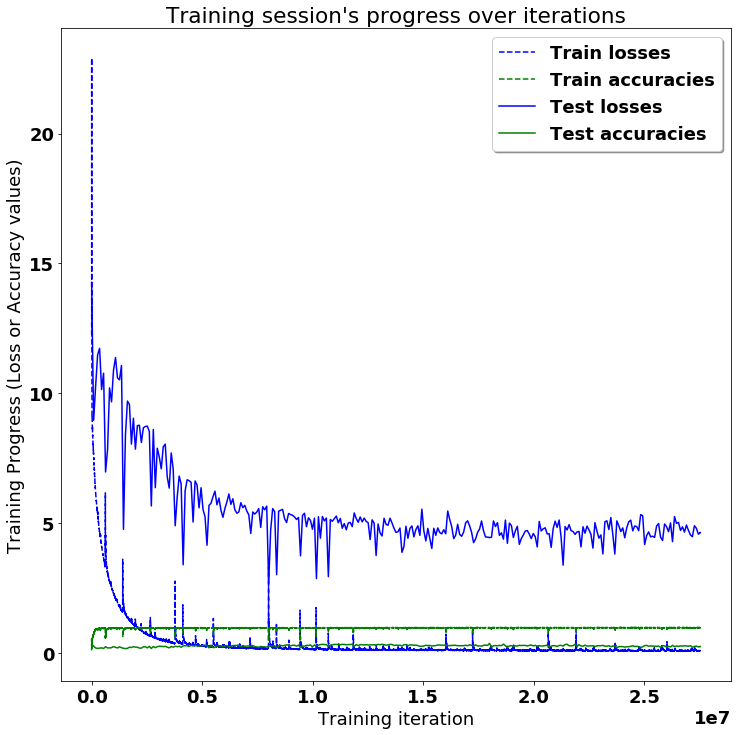

In [12]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## Multi-class confusion matrix and metrics

Testing Accuracy: 26.605504751205444%

Precision: 32.439194472945225%
Recall: 26.605504587155966%
f1_score: 26.670208521226797%

Confusion Matrix:
[[ 7  8 15  6  1]
 [ 6 12 13  5  2]
 [15 37 48 17  1]
 [ 4 47 54 20  1]
 [ 1  0  7  0  0]]

Confusion matrix (normalised to % of total test data):
[[ 2.1406727   2.4464834   4.587156    1.8348624   0.30581042]
 [ 1.8348624   3.6697247   3.9755352   1.529052    0.61162084]
 [ 4.587156   11.314984   14.678899    5.1987767   0.30581042]
 [ 1.2232417  14.37309    16.513762    6.116208    0.30581042]
 [ 0.30581042  0.          2.1406727   0.          0.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


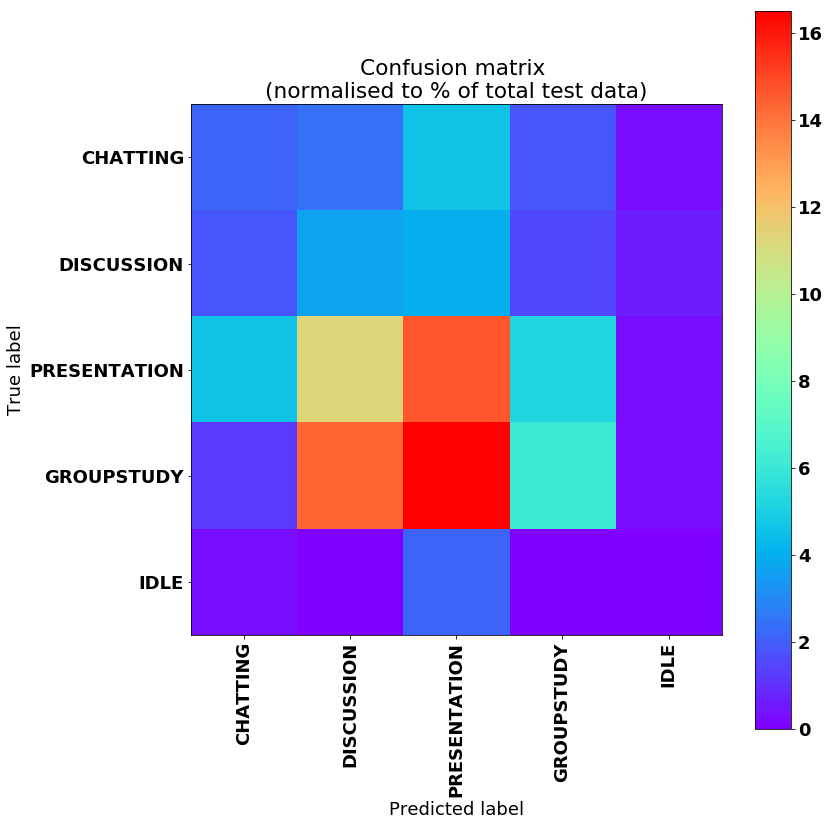

In [13]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
sess.close()